In [1]:
# Use needed libraries
using Random
using SSM
using Distributions
using Plots
using StatsBase
using CSV
using DataFrames
using LinearAlgebra

In [2]:
# Define paths and data parameters
data_path = "C:/Users/zachl/OneDrive/BU_YEAR1/Research/SMM_Branch/ssm_julia/TD1d_R4C_Trials_Normalized_M1_225T_189N_26t.csv"
kin_path = "C:/Users/zachl/OneDrive/BU_YEAR1/Research/SMM_Branch/ssm_julia/TD1d_R4C_Trials_Jaw_View1Y_for_normalized.csv"

timepoints = 225
neurons = 189
trials = 26

# Read the CSV file
data_df = CSV.read(data_path, DataFrame, header=false)
kin_path = CSV.read(kin_path, DataFrame, header=false)

# Convert DataFrame to a Matrix
data_matrix = Matrix(data_df)
kin_matrix = Matrix(kin_path)

kin_matrix = kin_matrix[:, 1:trials]

# Convert kinematics data to Vector{Vector{Float64}}
kin = [kin_matrix[:, i] for i in 1:size(kin_matrix, 2)]

# Reshape the data to a 3D array (timepoints, trials, neurons)
data_3d = reshape(data_matrix, timepoints, trials, neurons)

# Initialize the vector of matrices
X = Vector{Matrix{Float64}}(undef, trials)

# Populate the vector with each trial's data
for trial in 1:trials
    X[trial] = data_3d[:, trial, :]
end

# Check the shape of the first trial's data
println("Shape of X: ", size(X))
println("Shape of X[1]: ", size(X[1]))


Shape of X: (26,)
Shape of X[1]: (225, 189)


In [3]:
# Do a session wide regression and look at results
# Concatenate trials to a session
X_all = vcat(X...);
kin_all = vcat(kin...);

# Initialize regression model and regress
regression_model = SSM.RegressionEmissions(GaussianRegression())
SSM.update_emissions_model!(regression_model, X_all, kin_all);

# Get predicted kinematics and compare to real kinematics
kin_pred = hcat(ones(size(X_all, 1)), X_all) * regression_model.regression.β;

SS_res = sum((kin_all .- kin_pred) .^ 2)
SS_tot = sum((kin_pred .- mean(kin_all)) .^ 2)
r_squared = 1 - (SS_res / SS_tot)
println("R-Squared M1: ", r_squared)

R-Squared M1: 0.5323088117414954


In [4]:
# Create function to make design matrix for a trial
function trial_DM(N, tau, T, X_1, kin_1)
    # Initialize the design matrix
    design_matrix = zeros(T - tau + 1, N * tau)

    # Populate the design matrix
    for t in tau:T
        for n in 1:N
            design_matrix[t - tau + 1, (n - 1) * tau + 1:n * tau] = X_1[t - tau + 1:t, n]'
        end
    end
    
    # Clip the kinematics
    kin_adjusted = kin_1[tau:end];

    # Convert design_matrix to type Matrix{Float64}
    design_matrix = Matrix{Float64}(design_matrix)

return design_matrix, kin_adjusted
end

function session_DM(N, tau, T, X_2, kin_2)
    # Loop over trials to make session design matrix
    DM_session = Vector{Matrix{Float64}}()
    kin_adjusted_all = Vector{Vector{Float64}}()
    
    for i in 1:length(X)
        design_matrix, kin_adjusted = trial_DM(N, tau, T, X_2[i], kin_2[i])

        push!(DM_session, design_matrix)
        push!(kin_adjusted_all, kin_adjusted)
    end

return DM_session, kin_adjusted_all
end

session_DM (generic function with 1 method)

In [5]:
# Get design matrix
N = neurons
tau = 10
T = timepoints

DM_session, kin_adjusted_all = session_DM(N, tau, T, X, kin)

# Do the regression
kin = vcat(kin_adjusted_all...)
DM = vcat(DM_session...)
kernel_regression_model = SSM.RegressionEmissions(GaussianRegression())
SSM.update_emissions_model!(kernel_regression_model, DM, kin);

# Get predicted kinematics and compare to real kinematics
kin_pred = hcat(ones(size(DM, 1)), DM) * kernel_regression_model.regression.β;

SS_res = sum((kin .- kin_pred) .^ 2)
SS_tot = sum((kin_pred .- mean(kin)) .^ 2)
r_squared = 1 - (SS_res / SS_tot)
println("Kernel Size: ", tau)
println("R-Squared M1: ", r_squared)


Kernel Size: 10
R-Squared M1: 0.8262847345116122


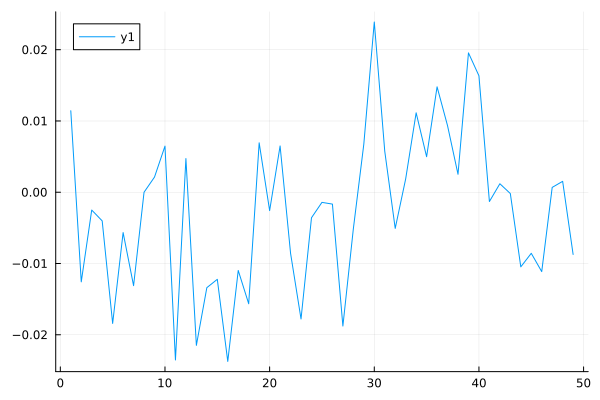

In [11]:
plot(kernel_regression_model.regression.β[2:50])